## Settings...

In [13]:
from subprocess import call
from urllib import urlretrieve
import os
import gzip
import binascii
import struct
import numpy
import sys
import tensorflow
from matplotlib import pyplot

%matplotlib inline

save_dir = '/notebooks/mnist'

download_base_url = 'http://yann.lecun.com/exdb/mnist/'

filenames = [
    'train-images-idx3-ubyte.gz', #:  training set images (9912422 bytes) 
    'train-labels-idx1-ubyte.gz', #:  training set labels (28881 bytes) 
    't10k-images-idx3-ubyte.gz',  #:   test set images (1648877 bytes) 
    't10k-labels-idx1-ubyte.gz'   #:   test set labels (4542 bytes)
]


/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


## Grab the MNist files...

In [14]:
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
for f in filenames:
    fullpath = os.path.join(save_dir, f)
    downloadurl = download_base_url + f
    print "Path", fullpath
    if os.path.exists(fullpath):
        print "Nothing to do."
    else:
        print "Downloading", downloadurl, "..."
        urlretrieve(downloadurl, fullpath)
        print "... done"

Path /notebooks/mnist/train-images-idx3-ubyte.gz
Nothing to do.
Path /notebooks/mnist/train-labels-idx1-ubyte.gz
Nothing to do.
Path /notebooks/mnist/t10k-images-idx3-ubyte.gz
Nothing to do.
Path /notebooks/mnist/t10k-labels-idx1-ubyte.gz
Nothing to do.


## Load data file and parse

In [15]:
%matplotlib inline

def progress_dot():
    sys.stdout.write('.')
    sys.stdout.flush()

def unpack_int(data_file):
    data = data_file.read(4)
    data = struct.unpack('>i', data)[0]
    return data

def unpack_image(data_file):
    img = data_file.read(28 * 28)
    img = struct.unpack('B' * (28 * 28), img)
    img = numpy.array(img)
    img = (img - 128) / 255.0
    return img

def unpack_image_data(filename):
    print "Unpacking image", filename, "..."
    with gzip.open(os.path.join(save_dir, filename)) as data_file:
        fields = {
            'magic_number': unpack_int(data_file),
            'count': unpack_int(data_file),
            'rows': unpack_int(data_file),
            'columns': unpack_int(data_file),
        }
        image_count = fields['count']
        image_list = []
        if fields['magic_number'] != 2051:
            raise RuntimeError("Expected 2051 in first two bytes of file.")
        print "Reading", image_count, "images:"
        while(image_count > len(image_list)):
            if(len(image_list) % 1000 == 0):
                progress_dot()
            img = unpack_image(data_file)
            image_list.append(img)
        print "done"
        return fields, image_list

def unpack_labels(filename):
    print "Unpacking labels", filename, "..."
    with gzip.open(os.path.join(save_dir, filename)) as data_file:
        fields = {
            'magic_number': unpack_int(data_file),
            'count': unpack_int(data_file)
        }
        if fields['magic_number'] != 2049:
            raise RuntimeError("Expected 2049 in first two bytes of file.")
        print "Reading", fields['count'], 'labels:'
        label_data = data_file.read(fields['count'])
        label_list = struct.unpack('B' * fields['count'], label_data)
    print "... done"
    return fields, label_list

image_fields, image_list = unpack_image_data('train-images-idx3-ubyte.gz')
label_fields, label_list = unpack_labels('train-labels-idx1-ubyte.gz')
training = {
    'image_fields': image_fields,
    'image': image_list,
    'label_fields': label_fields,
    'label': label_list
}

image_fields, image_list = unpack_image_data('t10k-images-idx3-ubyte.gz')
label_fields, label_list = unpack_labels('t10k-labels-idx1-ubyte.gz')
testing = {
    'image_fields': image_fields,
    'image': image_list,
    'label_fields': label_fields,
    'label': label_list
}


Unpacking image train-images-idx3-ubyte.gz ...
Reading 60000 images:
............................................................done
Unpacking labels train-labels-idx1-ubyte.gz ...
Reading 60000 labels:
... done
Unpacking image t10k-images-idx3-ubyte.gz ...
Reading 10000 images:
..........done
Unpacking labels t10k-labels-idx1-ubyte.gz ...
Reading 10000 labels:
... done


## Show the images:

In [17]:

def pyplot_images(image_list):
    plot_count = len(image_list)
    _, plots = pyplot.subplots(1, plot_count)
    for i in range(plot_count):
        img = image_list[i]
        plot = plots[i]
        plot.imshow(img.reshape(28, 28), cmap=pyplot.cm.Greys)
            

##Training set 60000 images:


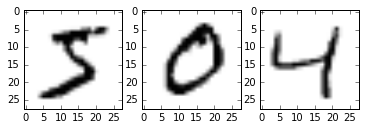

In [18]:
print "##Training set", training['image_fields']['count'], "images:"
pyplot_images([training['image'][0], training['image'][1], training['image'][2]])

##Testing set 10000 images:


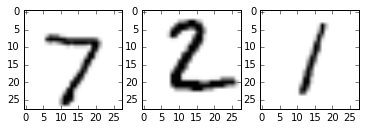

In [19]:
print "##Testing set", testing['image_fields']['count'], "images:"
pyplot_images([testing['image'][0], testing['image'][1], testing['image'][2]])

## The Labels:  

In [20]:
def pyplot_hist(hist_data_list):
  plot_count = len(hist_data_list)
  _, plots = pyplot.subplots(1, plot_count)
  for i in range(plot_count):
        hist_data = hist_data_list[i]
        plot = plots[i]
        plot.hist(hist_data, bins=10, range=[0,10])

Training Labels: (5, 0, 4) ...
Testing Labels: (7, 2, 1) ...


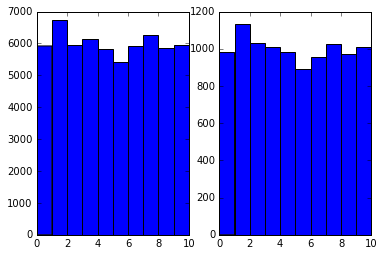

In [21]:
print "Training Labels:", training['label'][0:3], '...'
print "Testing Labels:", testing['label'][0:3], '...'
pyplot_hist([training['label'], testing['label']])

## Training...

In [29]:
def next_train_batch(i, n):
    batch_labels = training['label'][i : i + n]
    label_vec_list = []
    for label in batch_labels:
        label_vec = [0.0] * 10
        label_vec[label] = 1.0
        label_vec_list.append(label_vec)
    return training['image'][i : i + n], label_vec_list

# next_train_batch(0, 10)

In [30]:
import tensorflow

input_count = 28 * 28
output_count = 10
batch_size = 100
learning_rate = 0.5

x = tensorflow.placeholder(tensorflow.float32, [None, input_count])
w = tensorflow.Variable(tensorflow.zeros([input_count, output_count]))
b = tensorflow.Variable(tensorflow.zeros([output_count]))
y = tensorflow.nn.softmax(tensorflow.matmul(x, w) + b)
y_ = tensorflow.placeholder(tensorflow.float32, [None, output_count])
cross_entropy = tensorflow.reduce_mean(-tensorflow.reduce_sum(y_ * tensorflow.log(y), reduction_indices=[1]))
train_step = tensorflow.train.GradientDescentOptimizer(learning_rate).minimize(cross_entropy)
init = tensorflow.initialize_all_variables();
sess = tensorflow.Session()
sess.run(init)
    
for i in range(0, len(training['label']), batch_size):
    batch_xs, batch_ys = next_train_batch(i, batch_size)
    print "Training", batch_size, "starting with", i, "..."
    sess.run(train_step, feed_dict={x: batch_xs, y_: batch_ys})
    


Training 100 starting with 0 ...
Training 100 starting with 100 ...
Training 100 starting with 200 ...
Training 100 starting with 300 ...
Training 100 starting with 400 ...
Training 100 starting with 500 ...
Training 100 starting with 600 ...
Training 100 starting with 700 ...
Training 100 starting with 800 ...
Training 100 starting with 900 ...
Training 100 starting with 1000 ...
Training 100 starting with 1100 ...
Training 100 starting with 1200 ...
Training 100 starting with 1300 ...
Training 100 starting with 1400 ...
Training 100 starting with 1500 ...
Training 100 starting with 1600 ...
Training 100 starting with 1700 ...
Training 100 starting with 1800 ...
Training 100 starting with 1900 ...
Training 100 starting with 2000 ...
Training 100 starting with 2100 ...
Training 100 starting with 2200 ...
Training 100 starting with 2300 ...
Training 100 starting with 2400 ...
Training 100 starting with 2500 ...
Training 100 starting with 2600 ...
Training 100 starting with 2700 ...
Trai

In [62]:
test = [testing['image'][1]]
output = sess.run(y, feed_dict={x: test})
print max(output[0])
print "{:f}{:f}{:f}{:f}{:f}{:f}{:f}{:f}{:f}{:f}".format(output[0])

0.694661


ValueError: Unknown format code 'f' for object of type 'str'

In [ ]:
accuracy = tensorflow.reduce_mean(tensorflow.cast(correct_prediction, tensorflow.float32))

In [35]:
tensorflow.argmax(y,1)

<tf.Tensor 'ArgMax:0' shape=(?,) dtype=int64>

In [46]:
tensorflow.all_variables()

## Junk...